#Prodictive Model
The goal of this part of the project is to develop a predictive model to get an approximate prognosis of how COVID-19 could spread based on the recorded patterns in US counties. The main hypothesis is that counties have a different economic and social background prior to the pandemic, and these parameters could determine the way disease spread could unfold in these counties.

Based on this hypothesis, the follwong approach is suggested:
1. Retrieve data regarding the growth of the number of infected people for some set of counties
2. Approximate the COVID-19 incidence growth rate with a fixed-degree poynoal function (i.e.: approximate every county growth rate with a degree-3 polynomial
3. Split counties basing on their properties in several clusters
4. Find an average approximation for samples in each cluster

This approach can be declared to be reasonable if the clustered counties will have a recognizable similar patterns in the growth rate approximation. Each previously unknown county can be assigned to the cluster of best fit. After that the way pandemic unfolds is likely to be somewhat similar to the previously known counties in that cluster.

##Environment Setup

In [0]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

##Input Data
In this work 3 main datasets are used. All of these datasets are supposed to be provided in a csv format. ```pandas``` library is used as a very convenient tool to parse and analyse this data

In [0]:
cases = pd.read_csv('us-counties-4-26.csv')
mobility = pd.read_csv('DL-us-m50_index-4-23.csv')
econ = pd.read_csv('Unemployment.csv')

####Mobility
Includes how the mobility index was changing over time for various counties. It is provided in a row-wise fashion where each row represents a county and columns contain each measured day. First 4 columns include country and county data, that will be later used to join the datasets. Columns 5 and onwards represent dates. This unconventional data layout will not cause any significant impediments as the data will be later joined using our own script.

Highlighted columns:
* ```admin1``` - name of the state
* ```admin2``` - name of the county
* ```admin_level``` - takes value ```1``` if this row represents cumulative data for the whole state, and value ```2``` if the row includes a specific county

In [0]:
mobility.head(3)

,country_code,admin_level,admin1,admin2,fips,2020-03-01,2020-03-02,2020-03-03,2020-03-04,2020-03-05,2020-03-06,2020-03-07,2020-03-08,2020-03-09,2020-03-10,2020-03-11,2020-03-12,2020-03-13,2020-03-14,2020-03-15,2020-03-16,2020-03-17,2020-03-18,2020-03-19,2020-03-20,2020-03-21,2020-03-22,2020-03-23,2020-03-24,2020-03-25,2020-03-26,2020-03-27,2020-03-28,2020-03-29,2020-03-30,2020-03-31,2020-04-01,2020-04-02,2020-04-03,2020-04-04,2020-04-05,2020-04-06,2020-04-07,2020-04-08,2020-04-09,2020-04-10,2020-04-11,2020-04-12,2020-04-13,2020-04-14,2020-04-15,2020-04-16,2020-04-17,2020-04-18,2020-04-19,2020-04-21,2020-04-22,2020-04-23
0,US,1,Alabama,NaN,1.0,79.0,98.0,100.0,96.0,104.0,123.0,107.0,80.0,103.0,103.0,103.0,111.0,116.0,89.0,60.0,90.0,78.0,72.0,74.0,78.0,49.0,27.0,51.0,52.0,59.0,60.0,66.0,45.0,25.0,48.0,42.0,53.0,55.0,62.0,40.0,11.0,42.0,41.0,42.0,50.0,58.0,44.0,0.0,50.0,51.0,56.0,59.0,68.0,49.0,4.0,62.0,62.0,47.0
1,US,2,Alabama,Autauga County,1001.0,49.0,100.0,95.0,95.0,100.0,116.0,79.0,58.0,108.0,98.0,99.0,107.0,103.0,56.0,37.0,80.0,70.0,65.0,58.0,67.0,32.0,15.0,44.0,48.0,47.0,46.0,52.0,31.0,18.0,40.0,35.0,43.0,42.0,51.0,27.0,7.0,35.0,33.0,32.0,38.0,43.0,33.0,1.0,43.0,36.0,42.0,45.0,56.0,34.0,0.0,48.0,46.0,35.0
2,US,2,Alabama,Baldwin County,1003.0,81.0,100.0,95.0,90.0,102.0,114.0,95.0,82.0,96.0,99.0,100.0,104.0,112.0,90.0,79.0,79.0,72.0,70.0,71.0,94.0,55.0,35.0,55.0,53.0,55.0,54.0,61.0,45.0,26.0,43.0,41.0,50.0,49.0,56.0,36.0,10.0,37.0,39.0,41.0,46.0,51.0,39.0,1.0,48.0,49.0,52.0,53.0,57.0,43.0,16.0,58.0,59.0,36.0


Mobility dataset includes data for the following dates:

In [0]:
mobility_dates = mobility.columns[5:]
mobility_dates

Index(['2020-03-01', '2020-03-02', '2020-03-03', '2020-03-04', '2020-03-05',
       '2020-03-06', '2020-03-07', '2020-03-08', '2020-03-09', '2020-03-10',
       '2020-03-11', '2020-03-12', '2020-03-13', '2020-03-14', '2020-03-15',
       '2020-03-16', '2020-03-17', '2020-03-18', '2020-03-19', '2020-03-20',
       '2020-03-21', '2020-03-22', '2020-03-23', '2020-03-24', '2020-03-25',
       '2020-03-26', '2020-03-27', '2020-03-28', '2020-03-29', '2020-03-30',
       '2020-03-31', '2020-04-01', '2020-04-02', '2020-04-03', '2020-04-04',
       '2020-04-05', '2020-04-06', '2020-04-07', '2020-04-08', '2020-04-09',
       '2020-04-10', '2020-04-11', '2020-04-12', '2020-04-13', '2020-04-14',
       '2020-04-15', '2020-04-16', '2020-04-17', '2020-04-18', '2020-04-19',
       '2020-04-21', '2020-04-22', '2020-04-23'],
      dtype='object')

####Cases
This dataset includes the number of confirmed cases for each county. Each tuple includes its own date. It is important that the number of cases is cumulative.

In [0]:
cases.tail(3)

,date,county,state,fips,cases,deaths
89769,2020-04-25,Teton,Wyoming,56039.0,64,1
89770,2020-04-25,Uinta,Wyoming,56041.0,6,0
89771,2020-04-25,Washakie,Wyoming,56043.0,4,0


####Economic Performance
In order to evaluate how similar the counties are, several economic parameters will be used in this work. The decision was made to use US Census dataset, that focuses on unemployment and median household income. Highly likely, these parameters will be decisive in finding the similarities.

In [0]:
econ.head(3)

,FIPS,State,Area_name,Rural_urban_continuum_code_2013,Urban_influence_code_2013,Metro_2013,Civilian_labor_force_2007,Employed_2007,Unemployed_2007,Unemployment_rate_2007,Civilian_labor_force_2008,Employed_2008,Unemployed_2008,Unemployment_rate_2008,Civilian_labor_force_2009,Employed_2009,Unemployed_2009,Unemployment_rate_2009,Civilian_labor_force_2010,Employed_2010,Unemployed_2010,Unemployment_rate_2010,Civilian_labor_force_2011,Employed_2011,Unemployed_2011,Unemployment_rate_2011,Civilian_labor_force_2012,Employed_2012,Unemployed_2012,Unemployment_rate_2012,Civilian_labor_force_2013,Employed_2013,Unemployed_2013,Unemployment_rate_2013,Civilian_labor_force_2014,Employed_2014,Unemployed_2014,Unemployment_rate_2014,Civilian_labor_force_2015,Employed_2015,Unemployed_2015,Unemployment_rate_2015,Civilian_labor_force_2016,Employed_2016,Unemployed_2016,Unemployment_rate_2016,Civilian_labor_force_2017,Employed_2017,Unemployed_2017,Unemployment_rate_2017,Civilian_labor_force_2018,Employed_2018,Unemployed_2018,Unemployment_rate_2018,Median_Household_Income_2018,Med_HH_Income_Percent_of_State_Total_2018
0,0,US,United States,NaN,NaN,NaN,"152,191,093","145,156,134","7,034,959",4.6,153761095,144860350,8900745,5.8,"153,825,455","139,594,698","14,230,757",9.3,"154,270,732","139,408,204","14,862,528",9.6,"154,606,316","140,765,809","13,840,507",9.0,"155,119,195","142,600,402","12,518,793",8.1,"155,485,692","144,018,151","11,467,541",7.4,"155,957,297","146,338,305","9,618,992",6.2,"156,866,585","148,579,026","8,287,559",5.3,"158,708,795","150,981,151","7,727,644",4.9,"160,273,906","153,293,830","6,980,076",4.4,"161,640,488","155,344,043","6,296,445",3.9,"$61,937",NaN
1,1000,AL,Alabama,NaN,NaN,NaN,"2,175,612","2,089,127","86,485",4.0,"2,176,489","2,053,477","123,012",5.7,2162999,1924747,238252,11.0,"2,196,042","1,964,559","231,483",10.5,"2,202,670","1,990,413","212,257",9.6,"2,176,337","2,003,290","173,047",8.0,"2,174,000","2,017,043","156,957",7.2,"2,160,842","2,014,290","146,552",6.8,"2,158,293","2,026,898","131,395",6.1,"2,177,209","2,049,971","127,238",5.8,2178243,2081676,96567,4.4,"2,198,837","2,112,347","86,490",3.9,"$49,881",100.0
2,1001,AL,"Autauga County, AL",2.0,2.0,1.0,"24,383","23,577",806,3.3,"24,687","23,420","1,267",5.1,24703,22301,2402,9.7,"25,713","23,431","2,282",8.9,"25,836","23,677","2,159",8.4,"25,740","23,961","1,779",6.9,"25,810","24,205","1,605",6.2,"25,592","24,097","1,495",5.8,"25,613","24,283","1,330",5.2,"25,966","24,645","1,321",5.1,25972,24958,1014,3.9,"25,957","25,015",942,3.6,"$59,338",119.0


##Methodology
The methods used in this work will be illustrated in this section using a small subset of all the included data for a more convenient visualization. For this section the scope will be limited to a state of NY.

In [0]:
NY_mobility = mobility[mobility['admin1']=='New York']
NY_cases = cases[cases['state']=='New York']

NY_mobility_counties = NY_mobility['admin2'].unique()
NY_cases_counties = NY_cases['county'].unique()

The following function was developed to join the data and impose refinement needed in scope of this work. Since the goal is to model and predict the pattern of disease spread, the rate of change will be computed from a cumulative number of cases provided in ```cases``` dataset.

Mobility is assumed to have not an immediate effect on the disease spread, so it will be taken as a moving average of a 14-day period prior to each specific day. 

These 2 time series will be joined on a day resulting in the following data structures:
- ```fips``` code of that county
- tuple of lists, with their indices aligned on the same day (ex: day 0 is index 0 in both arrays) 
  - list of change of the nuber of the number of cases for each included day
  - moving average for a 14-day window ending at that day

In [0]:
def join_data(mobility, cases):
  ds = []
  for fips in mobility['fips']:
    cases_here = cases[cases['fips']==fips]
    if cases_here.empty:
      #print("No case info:\t",fips)
      continue
    mobility_row = mobility[mobility['fips']==fips].iloc[0][5:]
    m = np.array(mobility_row)
    m_a = [np.mean(m[i-14:i]) for i in range(14,len(m)+1)]

    c=[]
    for mobility_date in mobility_dates:
      mob_date = datetime.datetime.strptime(mobility_date, '%Y-%m-%d')
      cases_date = mob_date + datetime.timedelta(days=14)
      cases_date_str = cases_date.strftime('%Y-%m-%d')    
      
      cases_that_day = cases_here[cases_here['date']==cases_date_str]
      if cases_that_day.empty:
        c.append(0)
      else:
        c.append(cases_that_day['cases'].iloc[0])
    
    c = np.array(c)

    c=c[1:len(m_a)+1]  

  

    c_d = np.hstack(([0],np.diff(c)))
    c_d[c_d<0]=0
    m_d = np.hstack(([0],np.diff(m_a)))

    #print(fips)
    ds.append((int(fips),(c_d,m_a)))
    day_num = [i for i in range(0,len(c_d))]      
  return ds

ds = join_data(NY_mobility,NY_cases)
print(len(ds),'counties left after join')

56 counties left after join


###COVID spread pattern
As it can be seen in the chart below, NY counties were showing drastically different pattern of the disease spread, but some similarities in a plot shapes can be observed.

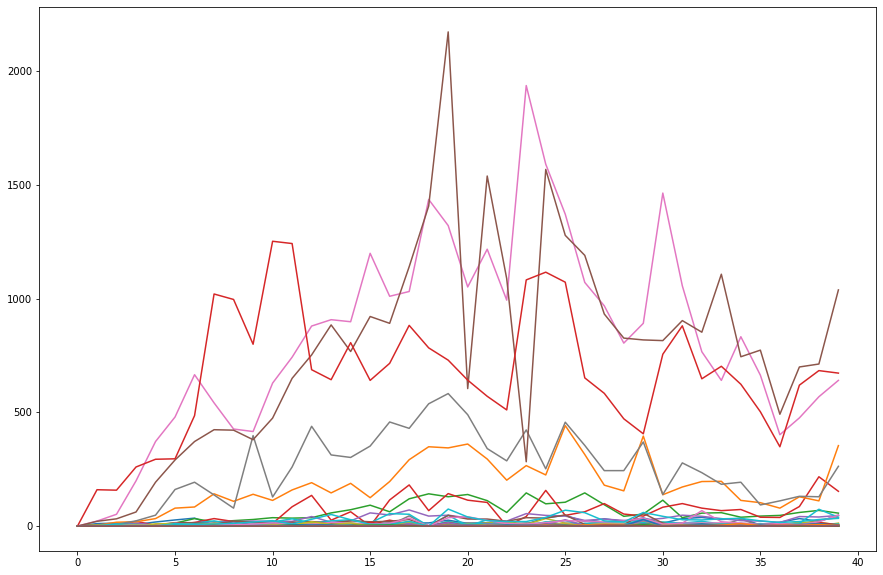

In [0]:
plt.figure(figsize=(15,10))
for fips,data in ds:
  c_d,m_a = data  
  day_num = [i for i in range(0,len(c_d))]  
  plt.plot(day_num,c_d)

3 counties were selected, where this function seemed to have a different behavior to a human observer:

In [0]:
highlight_fips_high = (26,36059)
highlight_fips_flat = (52,36117)
highlight_fips_waves = (13,36029)

These functions can be approximated using a polynomial. Degree 3 was selected, as it looks accurate enough to model the high growth rate at the main peak of the pandemy, and whether there is an emerging growth after the main peak.

In [0]:
def fit_model(item):
  c_d,m_a = item[1]  
  day_num = [i for i in range(0,len(c_d))]    
  model = np.polyfit(x=day_num, y=c_d, deg=3)
  return model

def show_model(item, coeffs, figsize=(10,5)):
  c_d,m_a = item[1]    
  day_num = [i for i in range(0,len(c_d))]

  plt.figure(figsize=figsize)
  plt.plot(day_num,c_d)
  model = np.poly1d(coeffs)
  preds = [model(x) for x in day_num]
  plt.plot(day_num, preds)

As it can be seen from the visualized models below, the selected model looks reasonable and effectively represents the major trends without introducing too high parameter space.

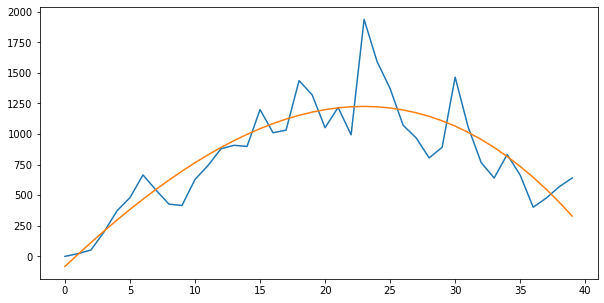

In [0]:
item = ds[highlight_fips_high[0]]
model = fit_model(item)
show_model(item,model)

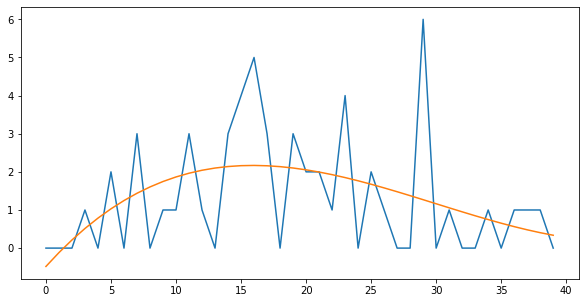

In [0]:
item = ds[highlight_fips_flat[0]]
model = fit_model(item)
show_model(item,model)

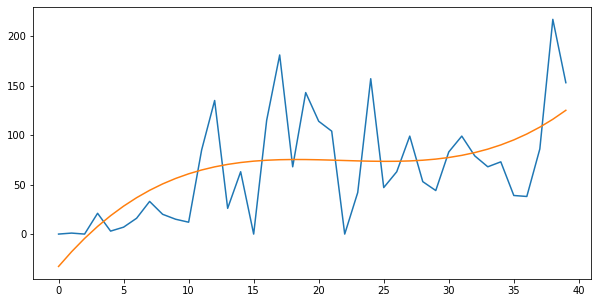

In [0]:
item = ds[highlight_fips_waves[0]]
model = fit_model(item)
show_model(item,model)

The models for all the NY counties are shown in the chart below. As it can be seen, the counties' disease spread patterns are effevely conveyed by the selected model.

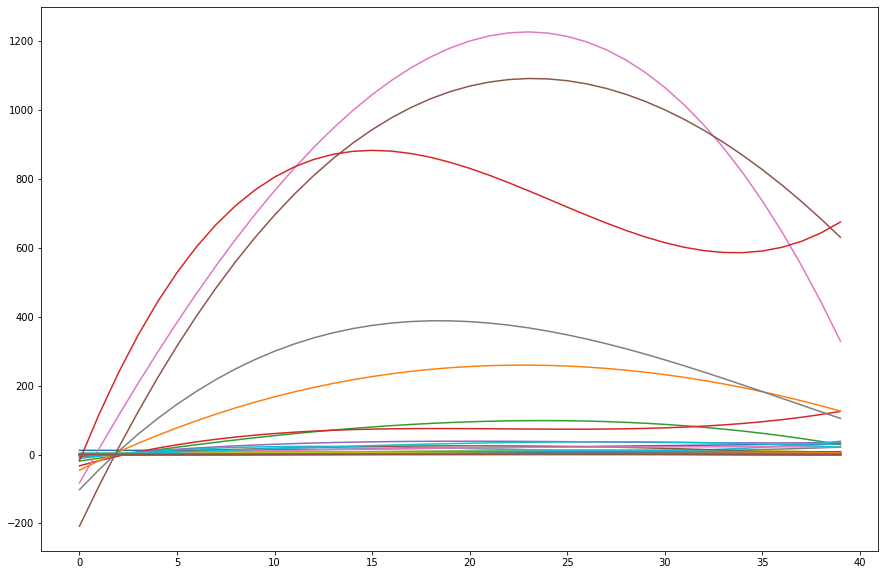

In [0]:
plt.figure(figsize=(15,10))
for county in ds:
  c_d,m_a = county[1]
  day_num = [i for i in range(0,len(c_d))]  
  
  coeffs = fit_model(county)
  model = np.poly1d(coeffs)
  preds = [model(x) for x in day_num]
  plt.plot(day_num, preds)

Therefore, a pool of models has been successfully created, and they can be now used to approximate disease patterns in new counties.

###County Clusterization
The goal now is to evaluate how similar or different are the counties. This is the part where economic daa will be used. Economic data was added to cluster counties based on the similarity of their economic standing. Economic indicators were chosen to be:
* ```Median_Household_Income``` - evaluates general level of life
* ```Unemployment_rate``` - estimates the percentage of poor people with a limited acess to resources
* ```Med_HH_Income_Percent_of_State_Total``` - shows how important this county is on a state level

In [0]:
def get_econ_data(list_of_fips):
  econ_data = []
  for fips in list_of_fips:
    econ_there = econ[econ['FIPS']==fips]
    econ_there = econ_there[['Unemployment_rate_2018','Median_Household_Income_2018','Med_HH_Income_Percent_of_State_Total_2018']]
    econ_there['Median_Household_Income_2018']=econ_there['Median_Household_Income_2018'].apply(lambda x: float(x[1:].replace(',', '')))
    econ_data.append(econ_there.to_numpy()[0])
  econ_data = np.array(econ_data)
  return econ_data

NY_econ_data = get_econ_data([fips for fips,data in ds])

Based on the economic performance, counties will be split in several groups. Number of groups is selected arbitrarily and is a subject for tuning to achieve a better model accuracy and fundamental applicability to a specific data subsets. In this case, the decision was made to use a ```K-Means``` algorithm to plit the NY counties in 3 clusters.

In [0]:
coeffs = [fit_model(county) for county in ds]
X = NY_econ_data

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)

Clusterization results can be seen in the chart below. It can be clearly seen, that counties with a different economic performance have a different patterns of disease spread. These 3 clusters can be clearly seen in the pool of models.

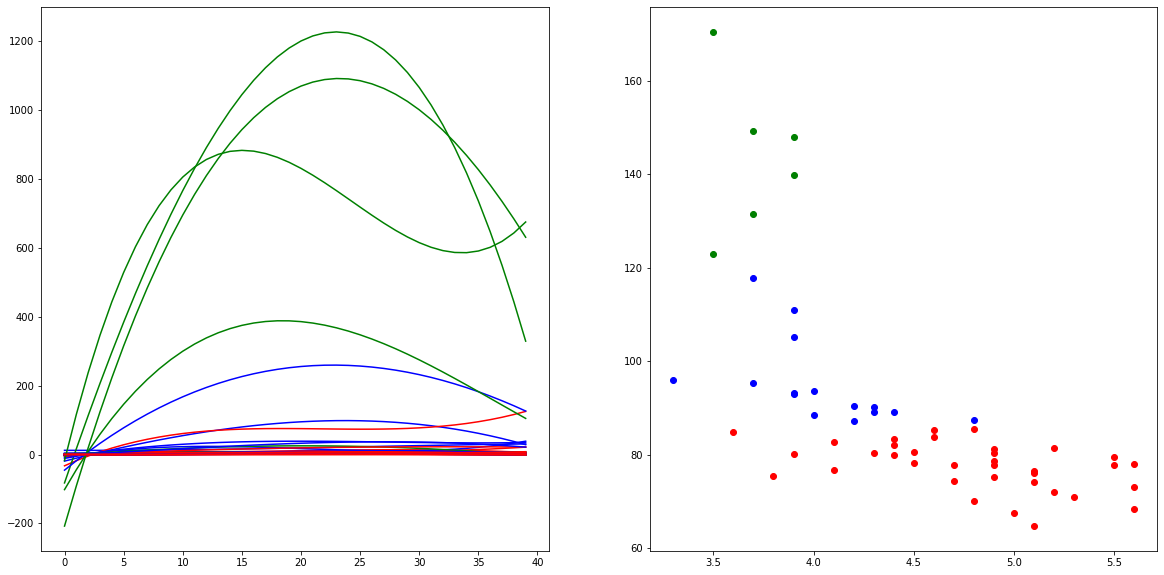

In [0]:
fig, (left, right) = plt.subplots(1, 2,figsize=(20,10))
colors = ['red','green','blue','purple']

for county,coeff,cluster,x in zip(ds,coeffs,kmeans.labels_,X):
  c_d,m_a = county[1]
  day_num = [i for i in range(0,len(c_d))]  
  

  model = np.poly1d(coeff)
  preds = [model(x) for x in day_num]
  left.plot(day_num, preds, color=colors[cluster])

  x_a=x[0]
  y_a=x[2]
  right.scatter(x_a,y_a,color=colors[cluster] )

Once we have a pool of models splitted in several clusters based on an economic performance, it could be reasonable to derive an averaged pattern for each cluster. The averaging will be done as simply taking a mean for each model coefficient. 

It can be seen, that all the economic clusters show different averaged patterns. Now it is possible to predict, how the disease could be spreading in a state, basing on its economic performance.

In [0]:
labels = np.array(kmeans.labels_)
mods = np.hstack((np.array(coeffs),labels.reshape((-1,1))))

avg_models =[]
for c in np.unique(labels):
  this_models = mods[mods[:,-1]==c]
  avg_model = this_models.mean(axis=0)
  avg_models.append(avg_model[:4])

avg_models

[array([ 3.39049257e-04, -2.73728269e-02,  7.45933167e-01, -1.52240360e+00]),
 array([ 1.69138561e-02, -2.23614760e+00,  7.06885579e+01, -6.83540056e+01]),
 array([ 4.70308940e-04, -9.34224524e-02,  3.56815737e+00, -4.84003835e+00])]

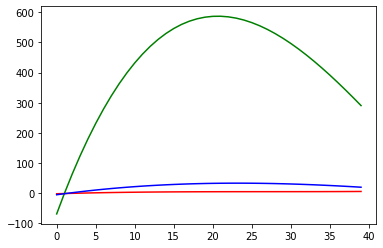

In [0]:
c=0
for avg_model in avg_models:
  model = np.poly1d(avg_model[:4])
  preds = [model(x) for x in day_num]
  plt.plot(day_num, preds, color=colors[c])
  c+=1

###Prediction
Using a this pool of averaged models to predict 3 arbitrary counties from a list.

In [0]:
test_indexes = [20,23,19]
train_indexes = [i for i in range(0,len(ds)) if i not in test_indexes]
train = [ds[i] for i in range(0,len(ds)) if i not in test_indexes]
test = [ds[i] for i in range(0,len(ds)) if i in test_indexes]

In [0]:
econ_train = get_econ_data([fips for fips,data in train])
econ_test = get_econ_data([fips for fips,data in test])

In [0]:
from sklearn.cluster import KMeans
def fit_data(econ_train,train,num_clusters):
  kmeans = KMeans(n_clusters=num_clusters, random_state=0)
  train_labels = kmeans.fit(econ_train).labels_

  train_coeffs = [fit_model(x) for x in train]
  mods = np.hstack((np.array(train_coeffs),train_labels.reshape((-1,1))))

  avg_models =[]
  for c in np.unique(train_labels):
    this_models = mods[mods[:,-1]==c]
    avg_model = this_models.mean(axis=0)
    avg_models.append(avg_model[:4])

  return avg_models, kmeans


In [0]:
avg_models,kmeans = fit_data(econ_train,train,3)
train_labels = kmeans.labels_
test_labels = kmeans.predict(econ_test)

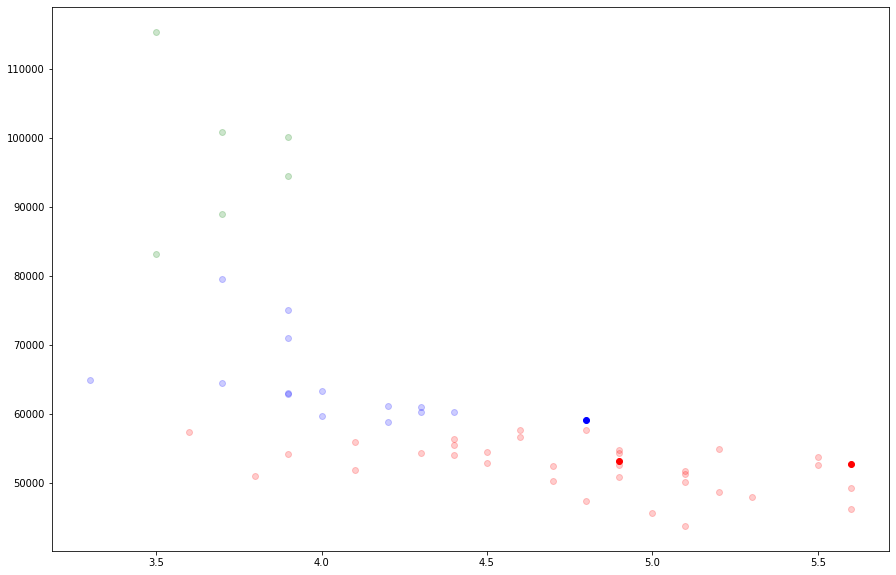

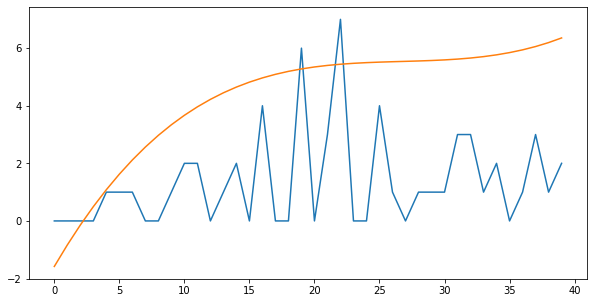

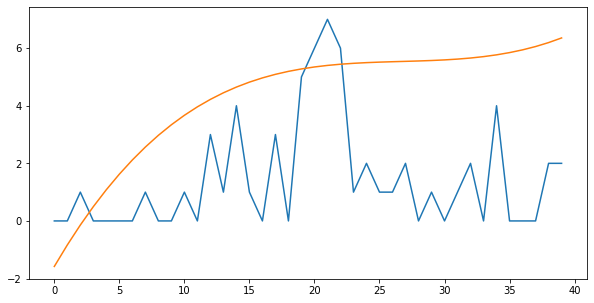

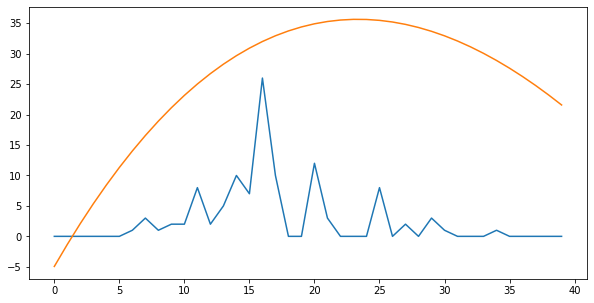

In [0]:
plt.figure(figsize=(15,10))
for x,label in zip(econ_train,train_labels):
  x_a=x[0]
  y_a=x[1]
  plt.scatter(x_a,y_a,color=colors[label], alpha=0.2)

for x,label in zip(econ_test,test_labels):
  x_a=x[0]
  y_a=x[1]
  plt.scatter(x_a,y_a,color=colors[label] )

for county,x,label in zip(test,econ_test,test_labels):  
  show_model(county,avg_models[label])


As it can be seen, the pool of averaged models is not extremely accurate, but reflects a general situation in each county from a test set.

#Real Runs
Now the proposed methodology will be used on a dataset of all the US counties. 

In [0]:
colors = ['red','green','blue','purple','black','magenta','yellow']

In [0]:
us = join_data(mobility,cases)

In [0]:
models = [fit_model(county) for county in us]

Since the All-US dataset contains much more samples than just NY data taken for Methodology section, in this part more clusters were used: ```5``` was assumed to be the most suitable number.

In [0]:
test_indexes = [20,23,19]
train_indexes = [i for i in range(0,len(us)) if i not in test_indexes]
train = [us[i] for i in range(0,len(us)) if i not in test_indexes]
test = [us[i] for i in range(0,len(us)) if i in test_indexes]

econ_train = get_econ_data([fips for fips,data in train])
econ_test = get_econ_data([fips for fips,data in test])

avg_models,kmeans = fit_data(econ_train,train,5)
train_labels = kmeans.labels_
test_labels = kmeans.predict(econ_test)

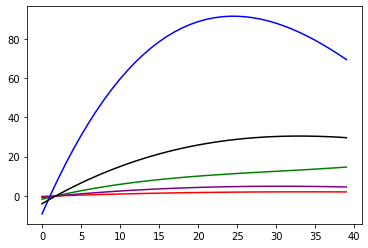

In [0]:
for i in range(0,len(avg_models)):
  model = np.poly1d(avg_models[i])
  preds = [model(x) for x in day_num]
  plt.plot(day_num, preds, color = colors[i])

As it can be seen, clusters are actually showing a different behavior even for all the counties over the US. Therefore, economic data is a reasonable predictor value for modelling the COVID-19 spread. The approach taken in this work is reasonable and can be extended in future work.

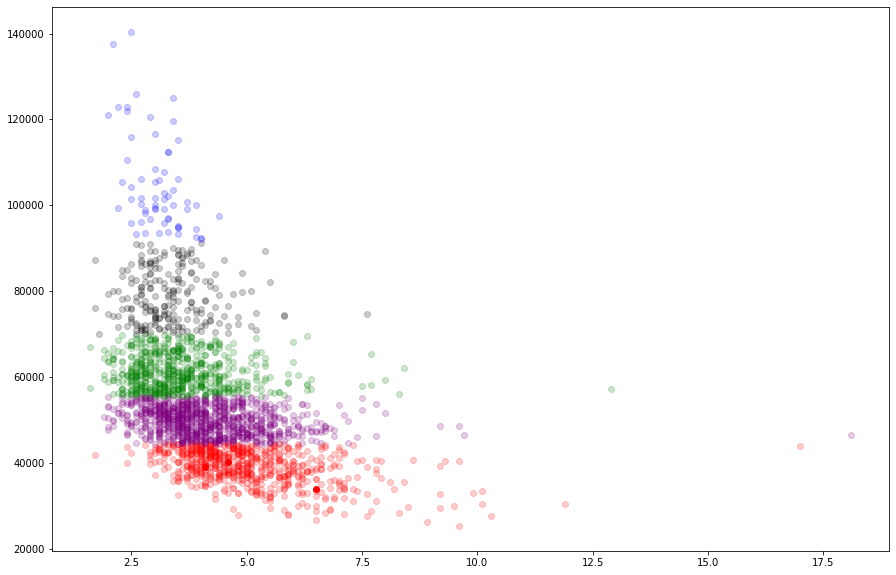

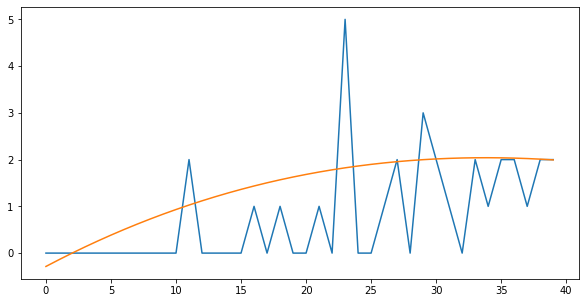

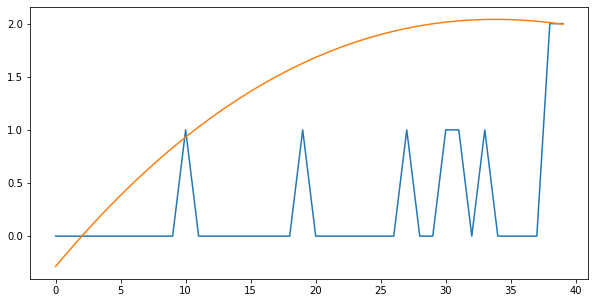

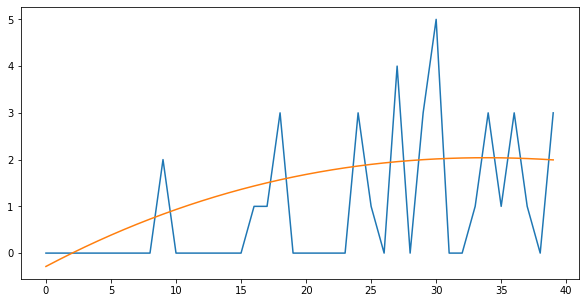

In [0]:
plt.figure(figsize=(15,10))
for x,label in zip(econ_train,train_labels):
  x_a=x[0]
  y_a=x[1]
  plt.scatter(x_a,y_a,color=colors[label], alpha=0.2)

for x,label in zip(econ_test,test_labels):
  x_a=x[0]
  y_a=x[1]
  plt.scatter(x_a,y_a,color=colors[label] )

for county,x,label in zip(test,econ_test,test_labels):  
  show_model(county,avg_models[label])

As it can be seen from the 3 test samples, the predicted models look reasonable given the data. This approach can be considered effective for the selected problem.

##Conclusions
The approach selected for the prediction part of our work is reasonable. It is true that the various counties have distinct patterns in the way COVID-19 was spreading there. Secondly, as the clusterization based on economic data has shown, COVID-19 spread patterns have been somewhat similar in the counties close in their socioeconomic standing. 

The proposed predictive model yield results that look reasonable as they reflect the previously unknown in a test set COVID-19 spread patters. Clusterization approach was working well in scope of this work, and could be used in the further development of the predictive models. 